In [13]:
import os

downloads_path = os.path.expanduser("~/Downloads/Fleet-Sustainment-HVAC-Project")
os.chdir(downloads_path)

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


/var/folders/9f/3yz89nb525nczbywh5dl11kh0000gn/T/ipykernel_1855/3174971943.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('Archive/2. ProcessedData/dataset.csv')


In [15]:
print(hvacdata.columns.tolist())

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


print(hvacdata.head(5))



['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'identification_number_closing', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'closing_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'component_status', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory

In [42]:
hvacdata['date_maintenance_action'] = pd.to_datetime(hvacdata['date_maintenance_action'], errors='coerce')

# group by `ship` to find the earliest date
first_maintenance_dates = (
    hvacdata.groupby('ship')['date_maintenance_action']
    .min()
    .reset_index()
    .rename(columns={'date_maintenance_action': 'first_maintenance_date'})
)

print(first_maintenance_dates)


     ship first_maintenance_date
0   CVN68             2017-11-02
1   CVN69             2017-11-01
2   CVN70             2017-11-01
3   CVN71             2017-11-04
4   CVN72             2017-11-01
5   CVN73             2017-11-02
6   CVN74             2017-11-01
7   CVN75             2017-11-02
8   CVN76             2017-11-01
9   CVN77             2017-11-01
10  CVN78             2017-11-01


In [53]:
hvacdata = hvacdata.merge(first_maintenance_dates, on='ship', how='left')


In [63]:
# column for calendar month
hvacdata['calendar_month'] = hvacdata['date_maintenance_action'].dt.to_period('M')


In [54]:
# calculate time since start of maintenance jobs

hvacdata['months_since_first_maintenance'] = (
    (hvacdata['date_maintenance_action'] - hvacdata['first_maintenance_date']) / np.timedelta64(1, 'M')
)


hvacdata['months_since_first_maintenance'] = (
    hvacdata['months_since_first_maintenance']
    .round()
    .astype('Int64')
)

hvacdata = hvacdata[hvacdata['ship'].notna()]


In [55]:
print(hvacdata[['ship', 'date_maintenance_action', 'first_maintenance_date', 'months_since_first_maintenance']].head())

    ship date_maintenance_action first_maintenance_date  \
0  CVN69              2018-07-16             2017-11-01   
1  CVN69              2018-07-16             2017-11-01   
2  CVN77              2018-07-16             2017-11-01   
3  CVN75              2018-05-11             2017-11-02   
4  CVN75              2018-05-11             2017-11-02   

   months_since_first_maintenance  
0                               8  
1                               8  
2                               8  
3                               6  
4                               6  


In [56]:
print(hvacdata.columns.tolist())


['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'identification_number_closing', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'closing_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'component_status', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory

In [57]:
hvacdata['computed_total_material_cost'] = hvacdata['unit_price'] * hvacdata['quantity']




In [58]:
job_summary = (
    hvacdata.groupby(['ship', 'months_since_first_maintenance'])
    .agg(
        num_jobs=('ship', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)

print(job_summary.head(10))


    ship  months_since_first_maintenance  num_jobs  total_material_cost
0  CVN68                               0       152            1184.8200
1  CVN68                               1        88            5883.6300
2  CVN68                               2       166           22249.2375
3  CVN68                               3       422           51977.9175
4  CVN68                               4       300            9381.6250
5  CVN68                               5       164           41598.1875
6  CVN68                               6       278            8723.3850
7  CVN68                               7       194           28921.8525
8  CVN68                               8       112            4791.1425
9  CVN68                               9       114            7569.3500


In [64]:
# groups data by ship, months_since_rcoh_start, and part


monthly_part_summary = (
    hvacdata.groupby(['ship', 'calendar_month', 'niin_nomenclature'])
    .agg(
        total_part_quantity=('quantity', 'sum'),
        num_jobs=('job_status', 'count'),
        total_material_cost=('computed_total_material_cost', 'sum')
    )
    .reset_index()
)


print(monthly_part_summary.head(20))


     ship calendar_month    niin_nomenclature  total_part_quantity  num_jobs  \
0   CVN68        2017-11               BELT,V                  4.0         2   
1   CVN68        2017-11   CONTACTOR,MAGNETIC                  2.0         2   
2   CVN68        2017-11   FILTER ELEMENT,AIR                160.0       142   
3   CVN68        2017-11  RELAY,ELECTROMAGNET                  2.0         2   
4   CVN68        2017-12   FILTER ELEMENT,AIR                 12.0        10   
5   CVN68        2017-12  HEATING ELEMENT,ELE                  6.0         6   
6   CVN68        2017-12   PARTS KIT,PRESSURE                  2.0         2   
7   CVN68        2017-12  PARTS KIT,REGULATIN                  2.0         2   
8   CVN68        2017-12  RELAY,ELECTROMAGNET                  2.0         2   
9   CVN68        2017-12                 RING                  4.0         4   
10  CVN68        2017-12       RING,RETAINING                  4.0         4   
11  CVN68        2017-12    TRANSFORMER,

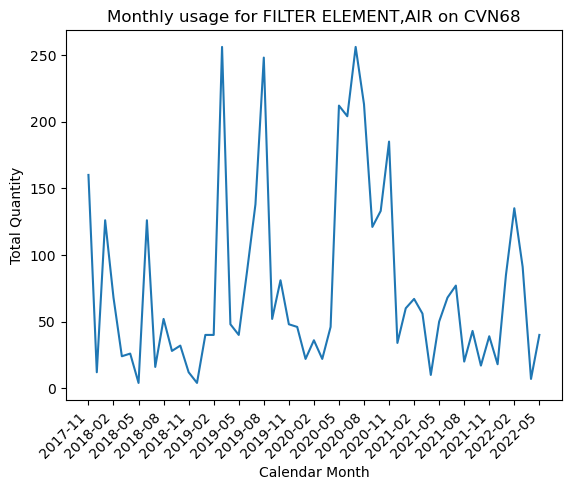

In [69]:
import matplotlib.pyplot as plt

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
]

plt.plot(part_data['calendar_month'].astype(str), part_data['total_part_quantity'])
plt.title(f"Monthly usage for {part} on {ship}")
plt.xlabel('Calendar Month')
plt.ylabel('Total Quantity')

# every 3rd month for readability
plt.xticks(
    ticks=range(0, len(part_data['calendar_month']), 3),
    labels=part_data['calendar_month'].astype(str)[::3],
    rotation=45,
    ha='right'
)

plt.show()


In [47]:
# some feature ideas that could go into model: num_jobs (more jobs = more parts), maintenace_duration (if jobs are taking longer, maybe more parts are needed), ship_age (older ships may need more replacement parts), months_since_rcoh_start, etc.